In [2]:
import numpy as np
import freegs
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import display, clear_output
import time

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Create the machine.

# First, identify files containing the machine description.
# freeGSNKE requires the user to define the following environment variables 
# ACTIVE_COILS_PATH
# PASSIVE_COILS_PATH
# WALL_PATH
# LIMITER_PATH
# These define the machine geometry and properties.
import os
os.environ["ACTIVE_COILS_PATH"] = "../machine_configs/MAST-U/active_coils.pickle"
os.environ["PASSIVE_COILS_PATH"] = "../machine_configs/MAST-U/passive_coils.pickle"
os.environ["WALL_PATH"] = "../machine_configs/MAST-U/wall.pickle"
os.environ["LIMITER_PATH"] = "../machine_configs/MAST-U/limiter.pickle"

# Now the machine can actually be built:
from freegsnke import build_machine
tokamak = build_machine.tokamak()



# Create the equilibrium and profile objects

# Creates the equilibrium object. 
# The equilibrium object indirectly defines the rectangular domain of the solver,
# as well as the grid resolution. 
eq = freegs.Equilibrium(tokamak=tokamak, #this assigns the machine just created above to the equilibrium
                        # the following define the rectangular domain
                        Rmin=0.1, Rmax=2.0,    # Radial range
                        Zmin=-2.2, Zmax=2.2,   # Vertical range
                        #grid resolution 
                        nx=65, # Number of grid points in the radial direction
                        ny=129, # Number of grid points in the vertical direction
                        # If available, an initial plasma flux function "plasma_psi" can be provided:
                        # psi=initial guess plasma_psi
                        )  


# Creates the profile object. 
# The profile object sets the parametrization and properties of the profile function. 
# freeGSNKE accepts the same profile classes available in freeGS: ConstrainPaxisIp or ConstrainBetapIp.
# The profile profile object also sets the value of the total plasma current.
# Example use of a ConstrainPaxisIp profile object:
from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(# Equilibrium and limiter objects are passed to the profile to inform calculations relating to the limiter
                            eq, tokamak.limiter,
                            # The following set the desired values for the profile properties
                            8.1e3, # Plasma pressure on axis [Pascals]
                            6.2e5, # Total plasma current [Amps]
                            0.5, # vacuum f = R*Bt
                            # The following are the coefficients that define the peakedness of the plasma current density distribution
                            # see e.g. arXiv:1503.03135
                            alpha_m = 1.8,
                            alpha_n = 1.2)
# Example use of a ConstrainBetapIp profile object, please un-comment the following:
# from freegsnke.jtor_update import ConstrainBetapIp
# profiles = ConstrainBetapIp(
#                               # Equilibrium and limiter objects are passed to the profile to inform calculations relating to the limiter:
#                               eq, tokamak.limiter,
#                               # The following set the desired values for the profile properties
#                               0.2, # value of beta_poloidal
#                               6.2e5, # Plasma current [Amps]
#                               0.5, # vacuum f = R*Bt
#                               # The following are the coefficients that define the peakedness of the plasma current density distribution
#                               # see e.g. arXiv:1503.03135
#                               alpha_m = 1.8,
#                               alpha_n = 1.2)

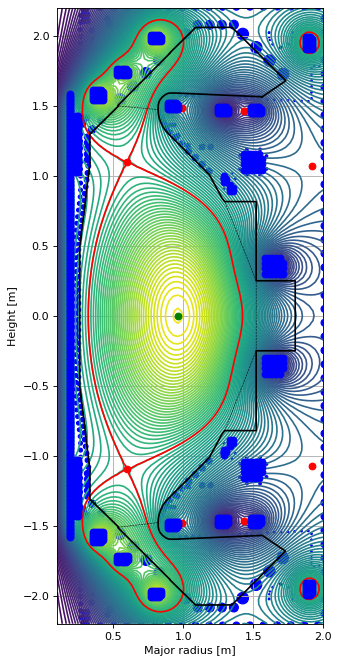

In [10]:
# Set initial equilibrium

# Assign current values to the active poloidal field coils 
# corresponding to a diverted plasma. 
# This assigns the passive structure currents too, in this specific case these are all set to zero.
import pickle
with open('simple_diverted_currents.pk', 'rb') as f:
    current_values = pickle.load(f)
for key in current_values.keys():
    eq.tokamak[key].current = current_values[key]

# Instantiate freeGSNKE static GS solver
from freegsnke import GSstaticsolver
# This requires use of the equilibrium itself to inform the solver of the domain and grid properties:
NK = GSstaticsolver.NKGSsolver(eq)
# Solve the forward GS problem corresponding to the tokamak metal currents set above and the requested profile properties
NK.solve(# The Equilibrium object sets the currents 
         eq, 
         # The profile sets the desired plasma properties
         profiles,
         # The relative tolerance set for convergence
         target_relative_tolerance=1e-8)
# Plot the equilibrium
# As in freeGS, the full black line is the tokamak.wall.
# In addition to freeGS, the thin black dotted line shows the tokamak.limiter: 
# it shows the border of the region where the plasma is allowed to be.
fig = plt.figure(figsize=(5, 10), dpi=80)
ax = fig.add_subplot(111)
ax.grid(True,which='both')
eq.plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)


In [4]:
# Initialize the time-evolutive solver.
# This uses an equilibrium object to inform the solver of the machine and domain properties.
# The solver object can be used on different equilibria, but these need to have the same machine and domain properties as the one used in the instantiation.  
# The equilibrium and profile functions used at instantiation are also used as expansion point
# around which a linearization of the dynamics is calculated. 
from freegsnke import nonlinear_solve
stepping = nonlinear_solve.nl_solver(# The equilibrium and profile around which the linearization is calculated 
                                     eq=eq, profiles=profiles, 
                                     # The timestep dt by which the dynamics is advanced at every call of the solver
                                     full_timestep=1e-3, 
                                     # Resistivity of the plasma   
                                     plasma_resistivity=5e-7,
                                     )
# This 

# In absence of a policy, this calculates the active voltages U_active
# to maintain the currents needed for the equilibrium statically
U_active = (stepping.vessel_currents_vec*stepping.evol_metal_curr.R)[:stepping.evol_metal_curr.n_active_coils]

Input max_mode_frequency corresponds to  29  independent vessel normal modes in addition to the  12  active coils.
I'm building the linearization wrt the currents. This may take a minute or two.
0 deltaI =  2.6094142144398633 norm(deltaIy) = 10.011934963379414
1 deltaI =  1.4247131045634758 norm(deltaIy) = 9.981709231502043
2 deltaI =  1.3475217750605641 norm(deltaIy) = 9.980203463425047
3 deltaI =  1.303393043583788 norm(deltaIy) = 9.979800703514865
4 deltaI =  1.1644622415882517 norm(deltaIy) = 9.981854314711981
5 deltaI =  0.5500686251893133 norm(deltaIy) = 9.998188009835527
6 deltaI =  0.5356073005589336 norm(deltaIy) = 9.998490997531707
7 deltaI =  0.42098995311529536 norm(deltaIy) = 10.003788087376766
8 deltaI =  0.3945134920658003 norm(deltaIy) = 10.005476329778558
9 deltaI =  0.1134285585671761 norm(deltaIy) = 10.04196917456013
10 deltaI =  0.06307736628666352 norm(deltaIy) = 10.013237359838323
11 deltaI =  0.13203673374982694 norm(deltaIy) = 9.994304415892614
12 deltaI =  0.44

'Step: 49/49'

'current time t = 0.04900000000000004'

'current time step dt = 0.001'

starting: curr residual 9.931109963691915 0.8392987612803341
[0, 'psi cycle skipped', 0, 'times, psi_residual', 0.0004563564214835926]
[0, 'intermediate curr residual', 9.931109963691915, 0.8392987612803341]
[0, 'curr_coeffs = ', array([1.28674412])]
[0, 'full cycle curr residual', 0.6394898648856994, 0.0568904938494683]
[0, 'GS residual: ', 0.3320977925816958]
[1, 'psi cycle skipped', 1, 'times, psi_residual', 0.00014963598826377156]
[1, 'intermediate curr residual', 6.488962925201095, 0.7870889450879813]
[1, 'curr_coeffs = ', array([1.02172607])]
[1, 'full cycle curr residual', 0.027230303034825393, 0.004357395210298883]
[1, 'GS residual: ', 0.05863565847277239]
[2, 'psi cycle skipped', 2, 'times, psi_residual', 9.659568542414593e-05]
[2, 'psi_coeffs = ', array([-0.73928119, -0.80944374])]
[2, 'intermediate curr residual', 1.7094810145473114, 0.35565979319509405]
[2, 'curr_coeffs = ', array([1.04622822])]
[2, 'full cycle curr residual', 0.10676934692555871, 0.014575426475169153]
[2, 

Text(0, 0.5, 'Plasma elongation')

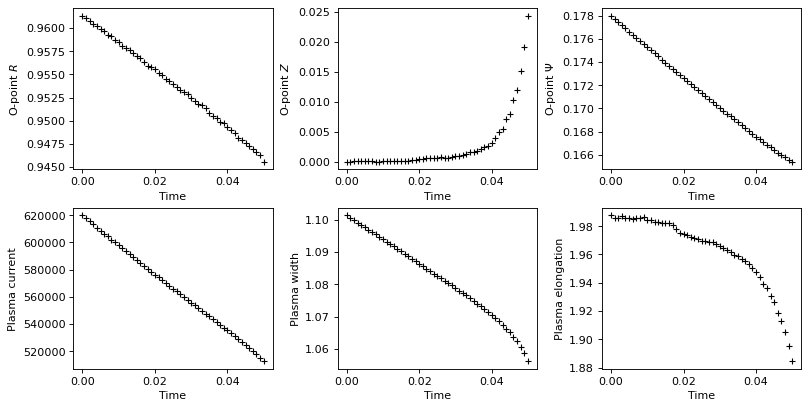

In [5]:
# Example of evolution with constant applied voltages
t = 0
flag = 0
history_times = [t]
t_per_step = []


#use the following to reset stepping.eq1 to a new IC
stepping.initialize_from_ICs(eq, profiles,
                            )
                            #  noise_level=.001, 
                            #  noise_vec=None,
                            #  update_linearization=False,
                            #  update_n_steps=12,
                            #  threshold_svd=.15)
# eqs = deepcopy(stepping.eq1)

history_currents = [stepping.currents_vec]
history_equilibria = [deepcopy(stepping.eq1)]
shapes = faster_shape.shapes_f(stepping.eq1, stepping.profiles1)
history_width = [shapes[0]]
history_o_points = shapes[1]
history_elongation = [shapes[2]]
# history_dJs = [stepping.dJ]

counter = 0
max_count = 50
while flag<1 and counter<max_count:
    clear_output(wait=True)
    display(f'Step: {counter}/{max_count-1}')
    display(f'current time t = {t}')
    display(f'current time step dt = {stepping.dt_step}')
    
    t_start = time.time()

    flag = stepping.nlstepper(active_voltage_vec=U_active, 
                                        target_relative_tol_currents=.005,
                                        target_relative_tol_GS=.005,
                                        
                                        # profile parameters are being jittered around at random 
                                        profile_parameter=8.1e3*(1+0.001*np.random.randn()),
                                        profile_coefficients=np.array([1.8*(1+0.0001*np.random.randn()),
                                                                       1.2*(1+0.0001*np.random.randn())]),

                                        # working_relative_tol_GS=.002,
                                        # target_relative_unexplained_residual=.5,
                                        # max_n_directions=3,
                                        # max_Arnoldi_iterations=3,
                                        # max_collinearity=.3,
                                        # step_size_psi=2.,
                                        # step_size_curr=.8,
                                        # scaling_with_n=0,
                                        # relative_tol_for_nk_psi=.002,
                                        # blend_GS=.5,
                                        # blend_psi=1,
                                        # curr_eps=1e-8,
                                        # max_no_NK_psi=1.,
                                        # clip=5,
                                        # threshold=1.5,
                                        # clip_hard=1.5,
                                        verbose=True,
                                        linear_only=False)       

   
    t_end = time.time()
    t_per_step.append(t_end-t_start)

    t += stepping.dt_step
    history_times.append(t)
    shapes = faster_shape.shapes_f(stepping.eq2, stepping.profiles2)

    history_currents.append(stepping.currents_vec)
    history_equilibria.append(deepcopy(stepping.eq2))
    history_width.append(shapes[0])
    history_o_points = np.append(history_o_points,shapes[1], axis=0)
    history_elongation.append(shapes[2])
    # history_dJs.append(stepping.dJ)
    counter += 1

history_currents = np.array(history_currents)
history_times = np.array(history_times)
history_o_points = np.array(history_o_points)


# Evolution of tracked values
fig, axs = plt.subplots(2, 3, figsize=(10, 5), dpi=80, constrained_layout=True)
axs_flat = axs.flat

axs_flat[0].plot(history_times, history_o_points[:, 0],'k+')
axs_flat[0].set_xlabel('Time')
axs_flat[0].set_ylabel('O-point $R$')

axs_flat[1].plot(history_times, history_o_points[:, 1],'k+')
axs_flat[1].set_xlabel('Time')
axs_flat[1].set_ylabel('O-point $Z$')

axs_flat[2].plot(history_times, history_o_points[:, 2],'k+')
axs_flat[2].set_xlabel('Time')
axs_flat[2].set_ylabel('O-point $\Psi$')

axs_flat[3].plot(history_times, history_currents[:,-1]*stepping.plasma_norm_factor,'k+')
axs_flat[3].set_xlabel('Time')
axs_flat[3].set_ylabel('Plasma current')

axs_flat[4].plot(history_times, history_width,'k+')
axs_flat[4].set_xlabel('Time')
axs_flat[4].set_ylabel('Plasma width')

axs_flat[5].plot(history_times, history_elongation,'k+')
axs_flat[5].set_xlabel('Time')
axs_flat[5].set_ylabel('Plasma elongation')

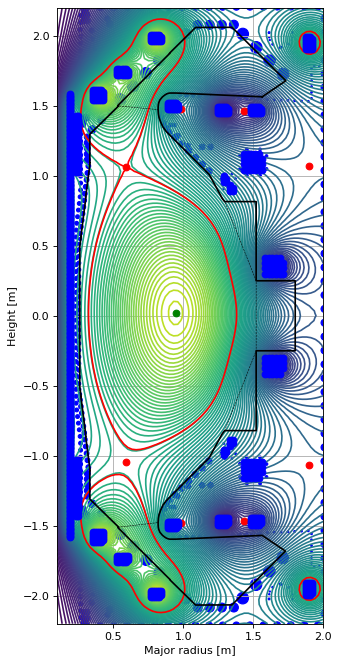

In [6]:
fig = plt.figure(figsize=(5, 10), dpi=80);
ax = fig.add_subplot(111);
ax.grid(True,which='both');
history_equilibria[-1].plot(axis=ax,show=False);
eq.tokamak.plot(axis=ax,show=False);